In [1]:
import os
import sys
import numpy as np
from pathlib import Path
from keras import datasets
import matplotlib.pyplot as plt
from typing import Optional, Any

# Add the path to the custom library to the system path
sys.path.append(str(Path().resolve().parent.parent))

# Import the module from the custom library
from src.models.data_loader import DataLoader
from src.architectures.sequential import Sequential
from src.models import TrainingArguments, LabeledData
from src.core.utils.data_processing import one_hot_encoding
from src.architectures.auto_encoder import ConditionalVAE, VAELoss
from src import Tensor, ModuleOutput, activations, optimizers, callbacks
from src.core.utils import data_analysis, data_processing, context_manager
from src.architectures.auto_encoder.config import VAEConfig, VAEEncoderConfig, VAEDecoderConfig, DenseConfig, Conv2DConfig, ConvTranspose2DConfig

### Constants and hyperparameters

In [2]:
# Path to where the model will be saved
model_path = os.path.join(os.getcwd(), 'checkpoints', 'conditional_variational_autoencoder')

In [3]:
n_samples = 1000 # Number of samples to generate
train_test_split_pct = 0.2 # Percentage of samples to use for testing
train_valid_split_pct = 0.2 # Percentage of samples to use for validation
learning_rate = 3e-04 # Learning rate for the optimizer
batch_size = 256 # Number of samples to use for each batch
epochs = 100 # Number of epochs to train the model
seed = 1234 # Seed for reproducibility
noise_factor = 0.6 # Noise to add to the data

In [4]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [5]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Add the channel dimension to the images
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Extract the number of classes in the dataset
num_classes = len(np.unique(train_labels))    

# Convert the lists to numpy arrays
X_train = Tensor(np.array(train_images))
y_train = Tensor(np.array(train_labels), dtype=np.int8)
X_test = Tensor(np.array(test_images))
y_test = Tensor(np.array(test_labels), dtype=np.int8)

# Split the training set into training, validation and testing sets
X_train, X_test, y_train, y_test = data_processing.split_data(data=(X_train, y_train), split_pct=train_test_split_pct, shuffle=True)[0]
X_train, X_valid, y_train, y_valid = data_processing.split_data(data=(X_train, y_train), split_pct=train_valid_split_pct, shuffle=True)[0]

# Print the dataset information
print("Number of classes:", num_classes)
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Number of classes: 10
Training set: (38400, 28, 28, 1) (38400,)
Validation set: (9600, 28, 28, 1) (9600,)
Testing set: (12000, 28, 28, 1) (12000,)


### Data processing

In [6]:
# Normalization
def normalize(X: Tensor) -> Tensor:
    """
    Normalize the input data by dividing by the maximum value in the training set.
    
    Parameters:
    - X (Tensor): The input data to normalize
    
    Returns:
    - Tensor: The normalized input data
    """
    
    # Normalize the input data
    return X / 255.0

# Normalize the input data
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

In [7]:
# Add noise to the input data
def add_noise(X: np.ndarray, noise: float) -> np.ndarray:
    """
    Add noise to the input data.
    
    Parameters:
    - X (np.ndarray): The input data to add noise to
    - noise (float): The noise to add to the input data

    Returns:
    - np.ndarray: The input data with noise added
    """
    
    # Add noise to the input data
    X_noisy = X + noise * np.random.normal(loc=0, scale=1.0, size=X.shape)
    
    # Clip the values to be between 0 and 1
    X_noisy = np.clip(X_noisy, 0., 1.)
    
    # Return the noisy input data
    return X_noisy


# Add noise to the input data
X_train_noisy = Tensor(add_noise(X_train.data, noise_factor))
X_valid_noisy = Tensor(add_noise(X_valid.data, noise_factor))
X_test_noisy = Tensor(add_noise(X_test.data, noise_factor))

In [8]:
# Convert the labels to one-hot encoding
y_train_one_hot = one_hot_encoding(y_train, n_classes=num_classes, dtype=np.float32)
y_valid_one_hot = one_hot_encoding(y_valid, n_classes=num_classes, dtype=np.float32)
y_test_one_hot = one_hot_encoding(y_test, n_classes=num_classes, dtype=np.float32)

### Data visualization

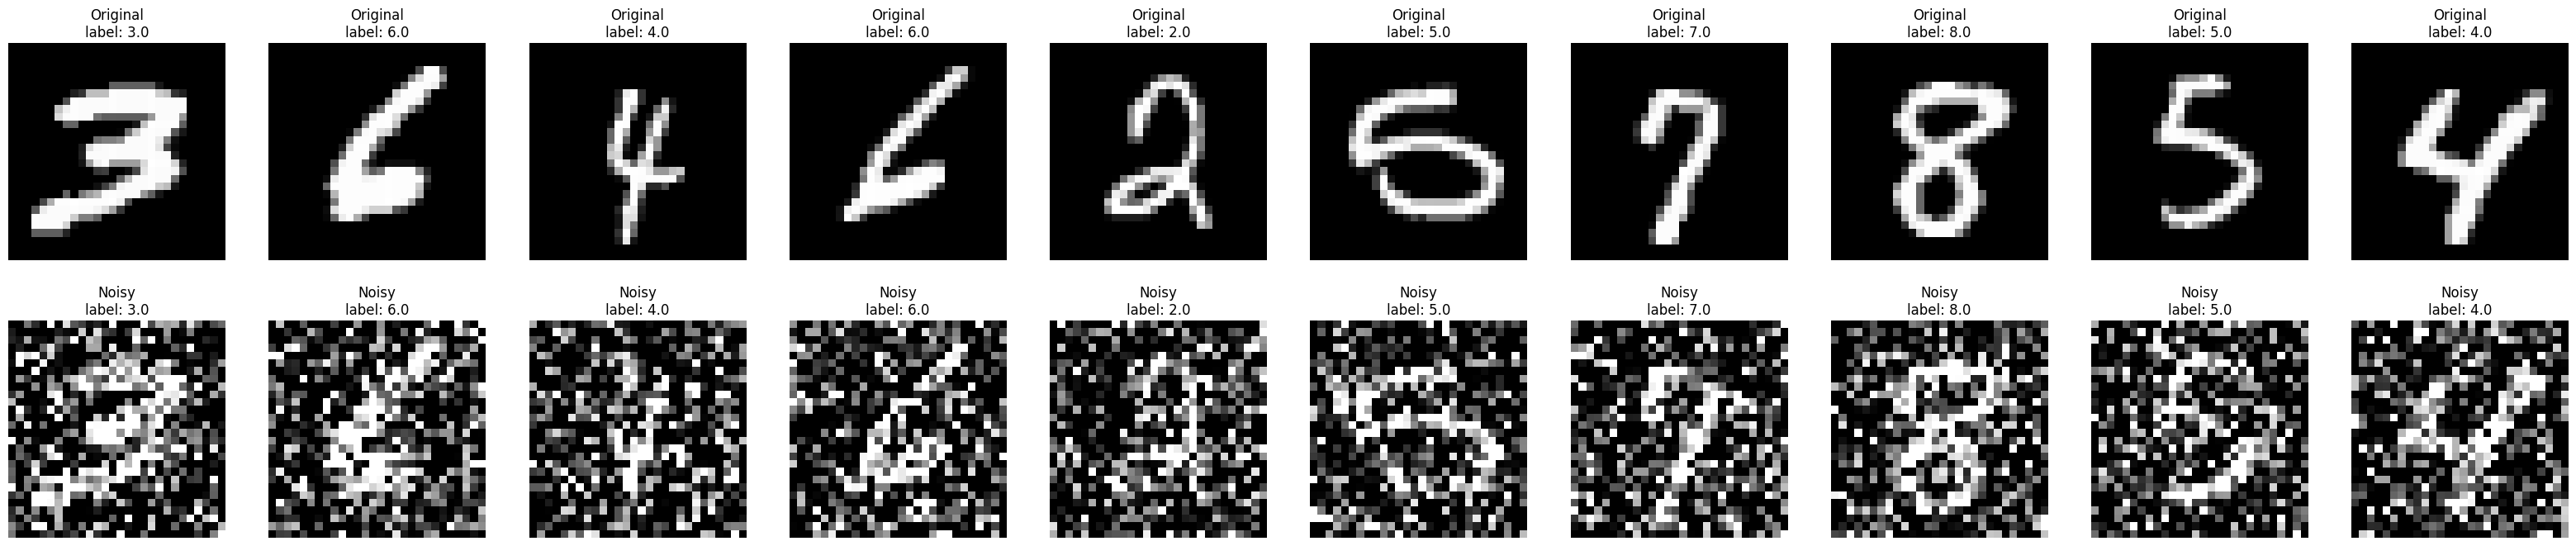

In [9]:
def plot_samples(originale_samples: list[np.ndarray], noisy_samples: Optional[list[np.ndarray]] = None, reconstructed_samples: Optional[list[np.ndarray]] = None, labels: Optional[list[np.ndarray]] = None) -> None:
    """
    Plot the samples in a grid.
    
    Parameters:
    - originale_samples (list[np.ndarray]): The original samples
    - noisy_samples (list[np.ndarray]): The noisy samples
    - reconstructed_samples (list[np.ndarray]): The reconstructed samples
    - labels (list[np.ndarray]): The labels of the samples
    """
        
    # Build a list of image types to plot along with their titles.
    plot_info = [('Original', originale_samples)]
    if noisy_samples is not None:
        plot_info.append(('Noisy', noisy_samples))
    if reconstructed_samples is not None:
        plot_info.append(('Reconstructed', reconstructed_samples))
        
    # Get the number of rows and samples.
    n_rows = len(plot_info)
    n_samples = len(originale_samples)
    
    # Create a grid: columns = samples, rows = image types.
    _, axes = plt.subplots(n_rows, n_samples, figsize=(n_samples * 4, n_rows * 4))
    
    # Ensure axes is a 2D array.
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0) 
    if n_samples == 1:
        axes = np.expand_dims(axes, axis=1)
    
    def add_image(ax: Any, image: np.ndarray, title: str) -> None:
        """
        Add an image to a subplot.
        
        Parameters:
        - ax (Any): The subplot to add the image to
        - image (np.ndarray): The image to add to the subplot
        - title (str): The title of the subplot
        """
        
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(title)
    
    # Loop over rows (image types) and columns (samples).
    for i, (title_prefix, samples) in enumerate(plot_info):
        for j in range(n_samples):
            # Append the label text if provided.
            add_image(axes[i, j], samples[j], f"{title_prefix}\nlabel: {labels[j]}" if labels is not None else title_prefix)
        
# Plot the first 10 samples
plot_samples(
    originale_samples = list(X_test.data[:10]),
    noisy_samples = list(X_test_noisy.data[:10]),
    labels = list(y_test.data[:10])
)

In [10]:
# Define the dimension of the latent space
latent_dim = 32

# Initialize the Conditional Variational Autoencoder model
conditional_vae = Sequential(
    name = "Conditional Variational Autoencoder",
    modules = [
        ConditionalVAE(
            num_classes = num_classes,
            vae_config = VAEConfig(
                encoder = VAEEncoderConfig(
                    conv = [
                        Conv2DConfig(
                            num_filters = 32, 
                            kernel_size = (3, 3), 
                            stride = (2, 2), 
                            padding = "same",
                            activation = activations.ReLU()
                        ),
                        Conv2DConfig(
                            num_filters = 64, 
                            kernel_size = (3, 3), 
                            stride = (2, 2), 
                            padding = "same",
                            activation = activations.ReLU()
                        )
                    ],
                    fc = [
                        DenseConfig(
                            num_units = latent_dim, 
                            activation = activations.ReLU()
                        )
                    ]
                ),
                latent_dim = latent_dim,
                decoder = VAEDecoderConfig(
                    fc = [
                        DenseConfig(
                            num_units = 7*7*64, 
                            activation = activations.ReLU()
                        )
                    ],
                    deconv = [
                        ConvTranspose2DConfig(
                            num_filters = 64, 
                            kernel_size = (3, 3), 
                            stride = (2, 2), 
                            padding = (1, 1), 
                            output_padding = (1, 1),
                            activation = activations.ReLU()
                        ),
                        ConvTranspose2DConfig(
                            num_filters = 32, 
                            kernel_size = (3, 3), 
                            stride = (2, 2), 
                            padding = (1, 1), 
                            output_padding = (1, 1),
                            activation = activations.ReLU()
                        ),
                        ConvTranspose2DConfig(
                            num_filters = 1, 
                            kernel_size = (3, 3), 
                            stride = (1, 1), 
                            padding = (1, 1), 
                            activation = activations.Sigmoid()
                        )
                    ]
                )
            )
        )
    ]
)

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate)

# Initialize the loss function with KL annealing
# Set the annealing to start at 0 and increase to the specified value
# over the first half of the epochs, then remain at the specified 
# valuefor the rest of the training
loss_fn = VAELoss(beta=0.15, annealing_epochs=(epochs // 2))

### Initializing the model

In [11]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    conditional_vae.eval()
    
    # Call the model with a batch of data to initialize it
    conditional_vae(X_train[:batch_size], y=y_train_one_hot[:batch_size])

In [12]:
# Display the encoder summary
conditional_vae.modules[0].encoder.summary()

# Display the decoder summary
conditional_vae.modules[0].decoder.summary()

# Display the model summary
conditional_vae.summary()


conditional_vae.encoder

-----------------------------------------------------------------------------------------------
Module (type)                                          Output Shape        Trainable params #  
encoder.conv_layers (ModuleList)                       ?                   18816               
-----------------------------------------------------------------------------------------------
encoder.flatten (Flatten)                              (256, 3136)         0                   
-----------------------------------------------------------------------------------------------
encoder.fc_layers (ModuleList)                         ?                   100704              
-----------------------------------------------------------------------------------------------
encoder.fc_mu (Dense)                                  (256, 32)           1056                
-----------------------------------------------------------------------------------------------
encoder.fc_log

### Training the model

In [13]:
# Define the training arguments
train_arguments = TrainingArguments(
    data_loader = DataLoader(
        train_data = LabeledData(input={'x': X_train_noisy, 'y': y_train_one_hot}, target=X_train),
        valid_data = LabeledData(input={'x': X_valid_noisy, 'y': y_valid_one_hot}, target=X_valid)
    ),
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_batch_size = batch_size,
    num_epochs = epochs,
    callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=10)]
)

# Train the model
history = conditional_vae.fit(train_arguments)

Epoch 1/100 --> loss: 0.32973 - rec_loss: 0.32973 - kl_divergence: 1.7147 | val_loss: 0.26294 - val_rec_loss: 0.26294 - val_kl_divergence: 3.0851    
Epoch 2/100 --> loss: 0.25964 - rec_loss: 0.25665 - kl_divergence: 0.996 | val_loss: 0.24964 - val_rec_loss: 0.24764 - val_kl_divergence: 0.66457    
Epoch 3/100 --> loss: 0.23512 - rec_loss: 0.23158 - kl_divergence: 0.58913 | val_loss: 0.21553 - val_rec_loss: 0.21133 - val_kl_divergence: 0.69973  
Epoch 4/100 --> loss: 0.20809 - rec_loss: 0.20281 - kl_divergence: 0.58723 | val_loss: 0.20036 - val_rec_loss: 0.19457 - val_kl_divergence: 0.64282  
Epoch 5/100 --> loss: 0.19913 - rec_loss: 0.19243 - kl_divergence: 0.55833 | val_loss: 0.19495 - val_rec_loss: 0.18804 - val_kl_divergence: 0.57504  
Epoch 6/100 --> loss: 0.19418 - rec_loss: 0.18652 - kl_divergence: 0.51068 | val_loss: 0.19256 - val_rec_loss: 0.18551 - val_kl_divergence: 0.47007  
Epoch 7/100 --> loss: 0.19081 - rec_loss: 0.18204 - kl_divergence: 0.48691 | val_loss: 0.18914 - val

In [14]:
# Save the model
conditional_vae.save(model_path)

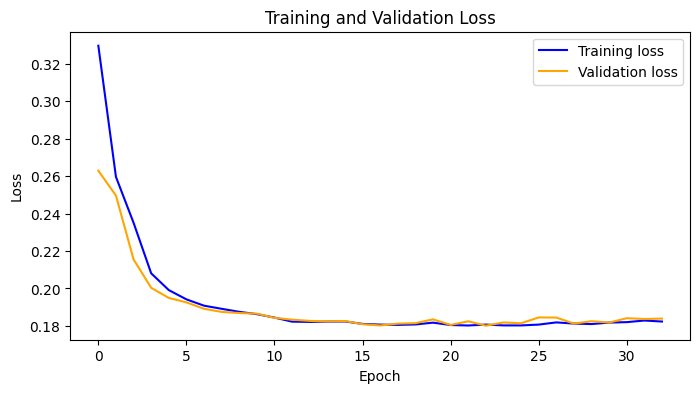

In [15]:
# Plot the training and validation loss
data_analysis.plot_history(
    train_loss = history["loss"], 
    valid_loss = history["val_loss"], 
    title = "Training and Validation Loss", 
    xlabel = "Epoch", 
    ylabel = "Loss"
)

### Inference

In [16]:
# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    conditional_vae.eval()

    # Denoise the test set
    X_test_out = conditional_vae(
        x = X_test_noisy,
        y = y_test_one_hot,
        batch_size = batch_size
    )

# Reshape the denoised test set
X_test_denoised = X_test_out.output.reshape((-1, *X_test.shape[1:]))

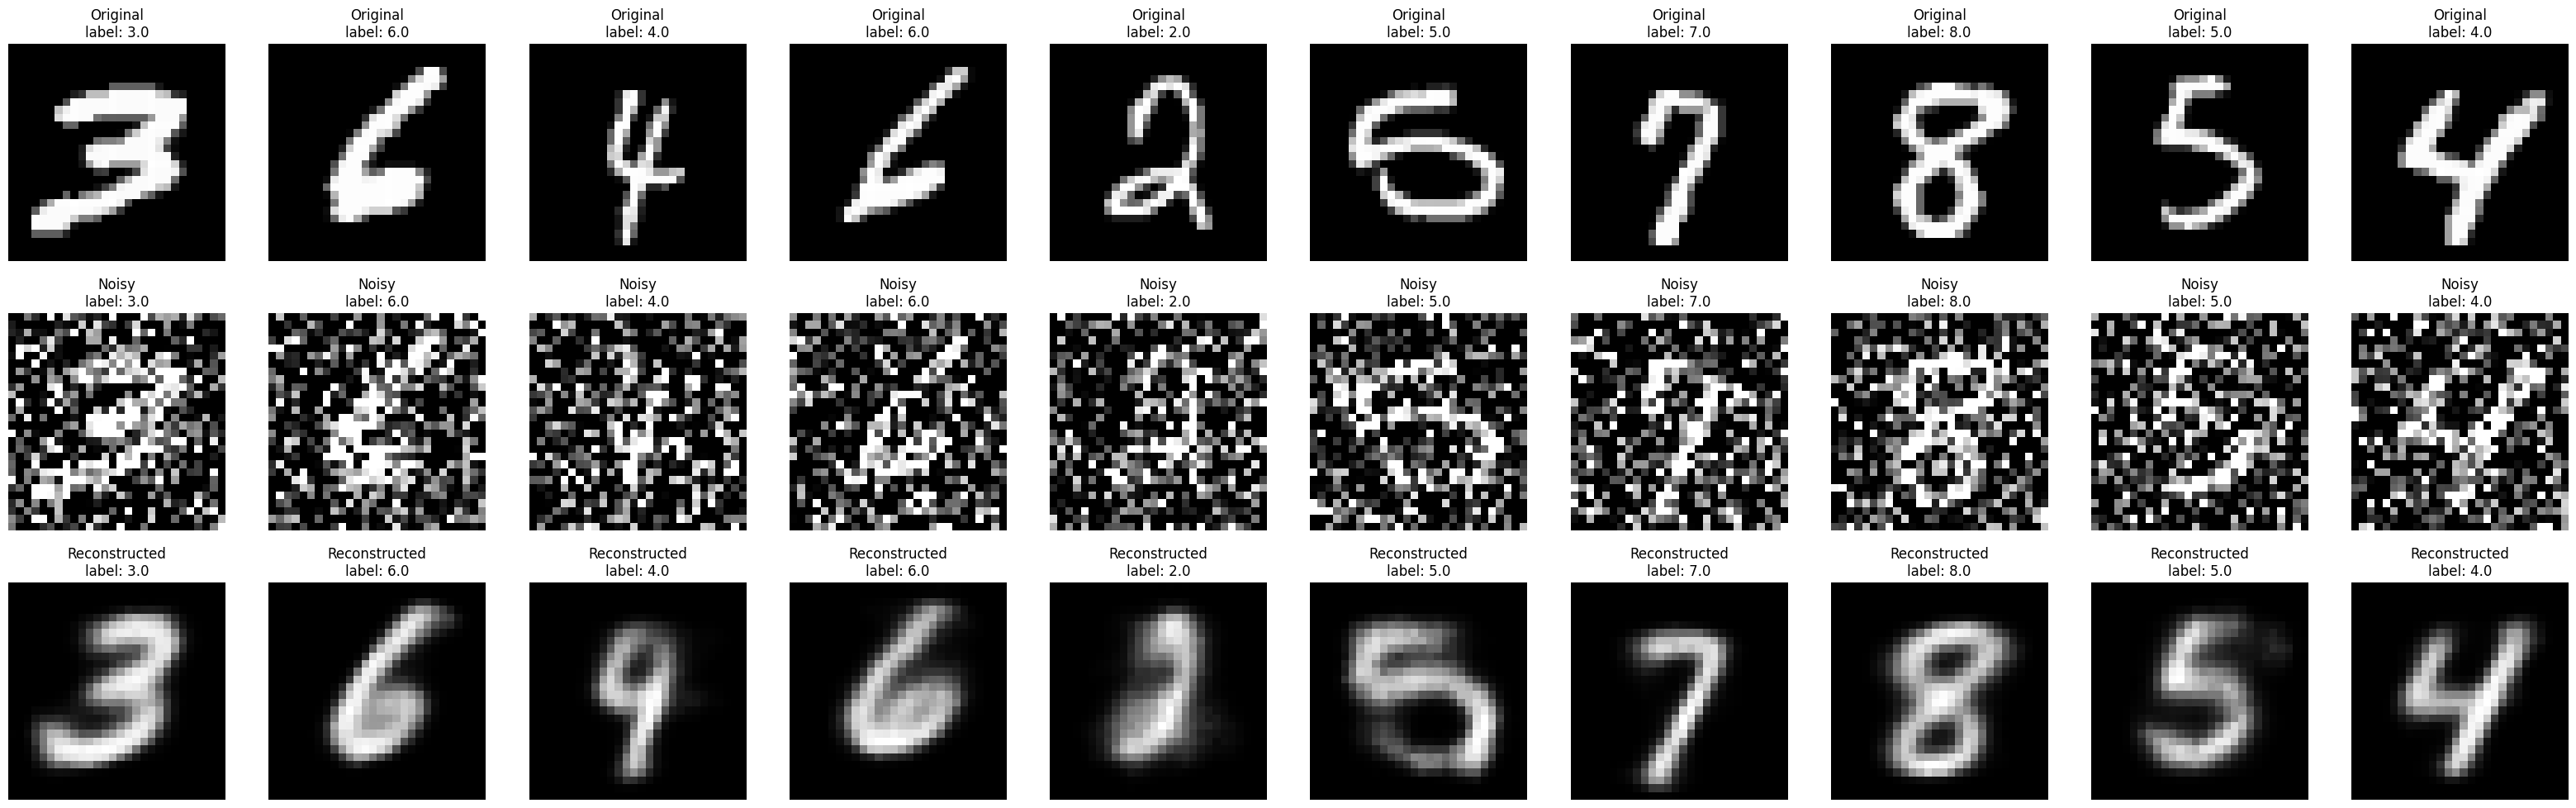

In [17]:
# Plot the first 10 samples
plot_samples(
    originale_samples = list(X_test.data[:10]),
    noisy_samples = list(X_test_noisy.data[:10]),
    reconstructed_samples = list(X_test_denoised.data[:10]),
    labels = list(y_test.data[:10])
)

### Generation

In [18]:
# Define how many samples to generate for each class
samples_per_class = 5

# Build a deterministic set of labels: 0..9 repeated
labels = np.repeat(np.arange(num_classes), samples_per_class)
labels_tensor = Tensor(labels, dtype=np.int8)
labels_one_hot = one_hot_encoding(labels_tensor, n_classes=num_classes)

# Sample latent vectors from the VAE prior: z ~ N(0, I)
z = Tensor(np.random.randn(len(labels), latent_dim), dtype=np.float32)

In [19]:
# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    conditional_vae.eval()

    # Access the ConditionalVAE module inside the Sequential container
    cvae: ConditionalVAE = conditional_vae.modules[0]

    # Generate images using only the decoder conditioned on labels
    generated: ModuleOutput = cvae.decoder(x=z, y=labels_one_hot)

# Extract generated images
generated_images: Tensor = generated.output.reshape((-1, *X_train.shape[1:]))

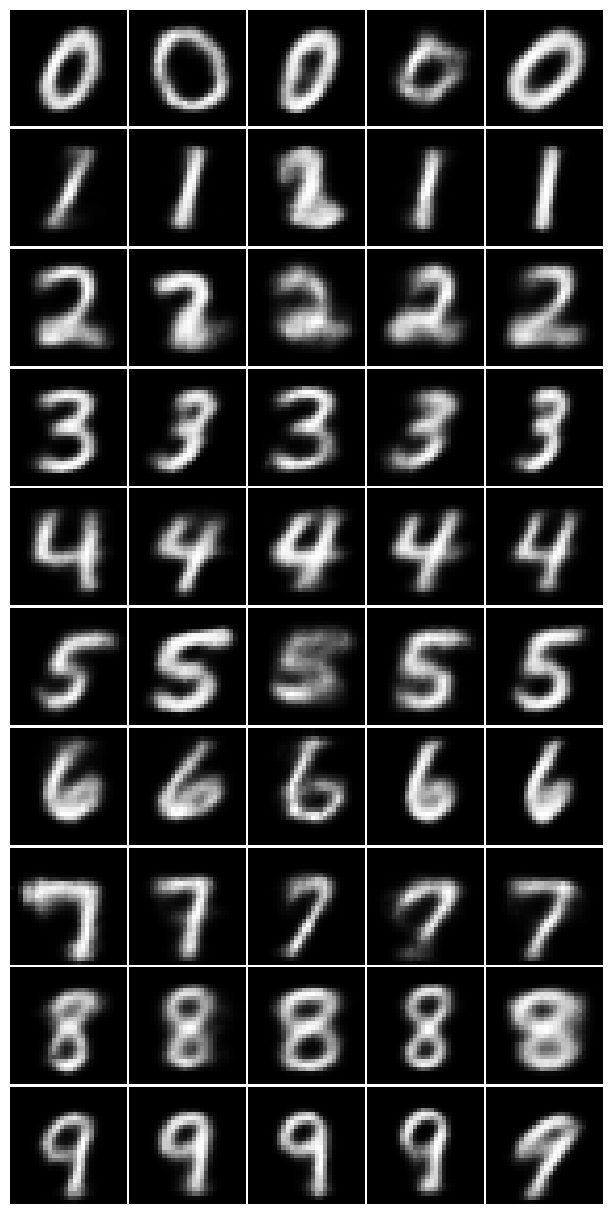

In [20]:
# Plot generated images grouped by target label
fig, axes = plt.subplots(
    num_classes,
    samples_per_class,
    figsize = (1.2 * samples_per_class, 1.2 * num_classes)
)

# Ensure axes is always 2D
if num_classes == 1:
    axes = np.expand_dims(axes, axis=0)
if samples_per_class == 1:
    axes = np.expand_dims(axes, axis=1)

# Iterate over classes
for cls in range(num_classes):
    for j in range(samples_per_class):
        # Calculate the index in the generated images for this class and sample
        idx = cls * samples_per_class + j
        ax = axes[cls, j]
        ax.imshow(generated_images.to_numpy()[idx], cmap="gray")
        ax.axis("off")

        # Display class label on the left
        if j == 0:
            ax.set_ylabel(f"Label {cls}", fontsize=9)

# Tight spacing and display the plot
plt.tight_layout(pad=0.2)
plt.show()